In [1]:
import os
import pandas as pd
import numpy as np
from scipy.constants import value
from tqdm import tqdm

from src.utils.utils import get_logger
import logging

from IPython.display import clear_output

logger = logging.getLogger(__name__)
logger = get_logger(logger=logger)

In [2]:
# Leitura dos dados históricos
grouped_data = pd.read_parquet("../data/processed/average_unity_price_historic.parquet")

In [3]:
# Deleção dos dados nulos
logger.info("Filtrando e corrigindo dados")
grouped_data.dropna(inplace=True)
grouped_data = grouped_data[(grouped_data["importador_uf"] != "") \
                            & (grouped_data["importador_municipio"] != "")].copy()

2024-03-08 17:13:21,920 - __main__ - INFO - Filtrando e corrigindo dados


In [4]:

# Correção de estados e municipios
estados_br = ["AC", "AL", "AP", "AM", "BA", "CE", "ES", "GO", "MA", "MT", "MS", "MG", "PA", "PB", "PR", "PE",
              "PI", "RJ", "RN", "RS", "RO", "RR", "SC", "SP", "SE", "TO", "DF"]

grouped_data["old_municipio"] = grouped_data["importador_municipio"]

logger.info("\tajustando importador UF")
grouped_data["importador_uf_new"] = grouped_data.apply(lambda x: x["importador_uf"] \
    if x["importador_uf"] in estados_br else x["importador_municipio"], axis=1)

logger.info("\tajustando importador municipio")
grouped_data["importador_municipio_new"] = grouped_data.apply(lambda x: x["old_municipio"] \
    if x["old_municipio"] not in estados_br else x["importador_uf"], axis=1)

grouped_data.drop(columns=['importador_municipio', "importador_uf", "old_municipio"], inplace=True)
grouped_data.rename(columns={"importador_municipio_new": "importador_municipio",
                   "importador_uf_new": "importador_uf"}, inplace=True)

2024-03-08 17:13:29,215 - __main__ - INFO - 	ajustando importador UF
2024-03-08 17:14:19,265 - __main__ - INFO - 	ajustando importador municipio


In [5]:
# Criação das chaves agrupadas
grouped_data["key"] = grouped_data["ncm"].astype(str) + '-' + grouped_data["id_pais_origem"] + '-' + \
                      grouped_data['importador_municipio'] + '-' + grouped_data['urf']

In [21]:
# Filtro de chaves que tiveram preços unitários registrados em 2024
keys_2_check = grouped_data[grouped_data["ano"]==2024]["key"].unique()
grouped_2_check = grouped_data[grouped_data["key"].isin(keys_2_check)].copy()
grouped_2_check = grouped_2_check[["key", "semestre", "ano", "anomes", "avg_valor_item"]].copy()
grouped_2_check["ano_semestre"] = grouped_2_check["ano"]*10 + grouped_2_check["semestre"]
grouped_2_check = grouped_2_check.groupby(["key", "ano_semestre"], as_index=False).mean("avg_valor_item")
# grouped_2_check["ano_semestre"] = grouped_2_check["ano_semestre"].astype(str)

In [27]:
# Pega do dado realizado interpolado
historic_data = pd.read_parquet("../data/processed/trended_data_interpolated_treated.parquet")
historic_data = historic_data[historic_data["ano"]<2024]
historic_data["key"] = historic_data["ncm"].astype(str) + '-' + historic_data["name_pt"] + '-' + \
                      historic_data['importador_municipio'] + '-' + historic_data['urf']

# Filtro do dados realizado interpolado somente para o que tem dado realizado em 2024
historic_data = historic_data[["key", "semestre", "ano","avg_valor_item"]].copy()
historic_data = historic_data[historic_data["key"].isin(keys_2_check)].copy()

# Junção do realizado interpolado + realizado em 2024
final_data = pd.concat([historic_data, grouped_2_check])
final_data["ano_semestre"] = final_data["ano"]*10 + final_data["semestre"]
final_data_gp = final_data.groupby(["key", "ano_semestre"], as_index=False).mean("avg_valor_item")
final_data_gp.sort_values(by=["key", "ano_semestre"], inplace=True)

# Pivot da tabela para facilitar a iteração dos grupos
final_data_pivot = final_data_gp.pivot(columns="ano_semestre", index="key", values="avg_valor_item")
final_data_pivot = final_data_pivot.dropna(subset=[20232, 20241])
# Aplicação da regra de queda ou aumento no valor unitário
final_data_pivot["trend_realizada"] = final_data_pivot.apply(lambda x: "aumento" if x[20232] < x[20241] else "queda",axis=1)

true_data = final_data_pivot[["trend_realizada"]].copy().reset_index()

In [30]:
# Checar as previsões
processed_data = pd.read_parquet("../data/processed/trended_data_interpolated_treated.parquet")
processed_data = processed_data[processed_data["ano"]>=2023]
processed_data["key"] = processed_data["ncm"].astype(str) + '-' + processed_data["name_pt"] + '-' + \
                      processed_data['importador_municipio'] + '-' + processed_data['urf']

processed_data["ano_semestre"] = processed_data["ano"]*10 + processed_data["semestre"]
processed_data = processed_data.groupby(["key", "ano_semestre"], as_index=False).mean("avg_valor_item")
processed_data.sort_values(by=["key", "ano_semestre"], inplace=True)

In [31]:
processed_data_pivot = processed_data.pivot(columns="ano_semestre", index="key", values="avg_valor_item")
processed_data_pivot["trend_projetada"] = processed_data_pivot.apply(lambda x: "aumento" if x[20232] < x[20241] else "queda",axis=1)
processed_data_trend = processed_data_pivot[["trend_projetada"]].copy().reset_index()
processed_data_trend.head()

ano_semestre,key,trend_projetada
0,1.00119E7-ARGENTINA-PASSO FUNDO-AEROPORTO INTE...,queda
1,1.00199E7-ARGENTINA-ALTOS-IRF - PORTO DE PECÉM,aumento
2,1.00199E7-ARGENTINA-ALTOS-IRF - PORTO DE SUAPE,queda
3,1.00199E7-ARGENTINA-ALTOS-PORTO DE SANTOS,queda
4,1.00199E7-ARGENTINA-AQUIRAZ-ALF - FORTALEZA,aumento


In [36]:
trend_n_real = processed_data_trend.merge(true_data, on="key")
trend_n_real[["trend_projetada", "trend_realizada"]].value_counts()

trend_projetada  trend_realizada
aumento          queda              5612
                 aumento            4396
queda            queda              4157
                 aumento            2153
dtype: int64

<Axes: >

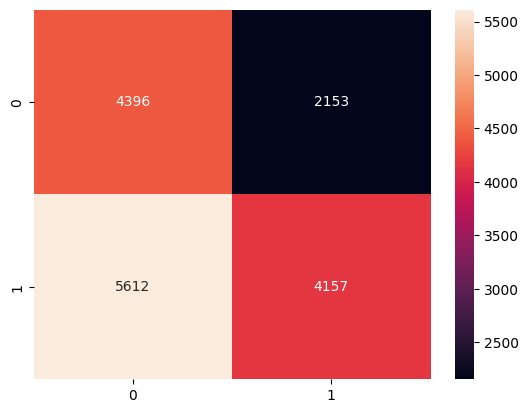

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(trend_n_real["trend_realizada"], trend_n_real["trend_projetada"]), annot=True, fmt='g')

In [35]:
trend_n_real["trend_realizada"].value_counts()

queda      9769
aumento    6549
Name: trend_realizada, dtype: int64

In [34]:
from sklearn 
trend_n_real["trend_projetada"].value_counts()

aumento    10008
queda       6310
Name: trend_projetada, dtype: int64

In [12]:
# Merge data
trend_n_real = processed_data_trend.merge(true_data, on="key")
trend_n_real["score"] = trend_n_real.apply(lambda x: 1 if x["trend_projetada"] == x["trend_realizada"] else 0,axis=1) 
trend_n_real["score"].value_counts()/trend_n_real.shape[0]

1    0.507354
0    0.492646
Name: score, dtype: float64